In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

2.8.0


In [ ]:
import os
import cv2
import numpy as np
import re
import glob
import shutil
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = '/content/drive/MyDrive/gray/'

In [ ]:
def train_test_split(dataset_dir: str, train_size: float):
    """
    splits data to train and test and moves them to the corresponding directories
    arguments:
        - dataset_dir: directory in which the dataset is stored,
        - train_size: from 0 to 1
    """
    os.chdir(dataset_dir)
    list_img = glob.glob('*.jpg')
    
    number_of_train_imgs = int(len(list_img) * train_size)
    train_imgs = sorted(list_img)[:number_of_train_imgs]
    test_imgs = sorted(list_img)[number_of_train_imgs:]
    
    for img in train_imgs:
        try:
            os.makedirs('train/')
        except FileExistsError:
            pass
        shutil.move(img, 'train/'+img)
        
    for img in test_imgs:
        try:
            os.makedirs('test/')
        except FileExistsError:
            pass
        shutil.move(img, 'test/'+img)

In [ ]:
train_test_split(path, 0.8)

In [ ]:
train_path = path + 'train/'
test_path = path + 'test/'

In [ ]:
def make_dataset(kind_of_data) :
    X = []
    if kind_of_data == 'train' :
        new_path = train_path
    elif kind_of_data == 'test' :
        new_path = test_path
    else:
        return 0
    
    
    #image_in_folder = [f for f in os.listdir(new_path) if re.match(r'[0-9]+.*\.jpg', f)]
    image_in_folder = os.listdir(new_path)
    # print(image_in_folder)
    print(len(image_in_folder))
    for i in range(len(image_in_folder)):
        img = tf.keras.preprocessing.image.load_img(
        new_path+'/'+str(image_in_folder[i]), color_mode='grayscale', target_size=(128,128,1),
        interpolation='nearest')
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        if (img.shape == (128,128,1)):
          X.append(img)
              
    return X

In [ ]:
x_train = make_dataset('train')
x_test = make_dataset('test')

['5300.jpg', '6084.jpg', '4988.jpg', '5746.jpg', '5113.jpg', '5332.jpg', '5149.jpg', '5142.jpg', '5313.jpg', '5095.jpg', '6071.jpg', '494.jpg', '5190.jpg', '4875.jpg', '5238.jpg', '4858.jpg', '5370.jpg', '5321.jpg', '6091.jpg', '4913.jpg', '515.jpg', '5583.jpg', '5446.jpg', '534.jpg', '5307.jpg', '5296.jpg', '5184.jpg', '6064.jpg', '5641.jpg', '5443.jpg', '4830.jpg', '5573.jpg', '5925.jpg', '5027.jpg', '5915.jpg', '5535.jpg', '5759.jpg', '6124.jpg', '6042.jpg', '563.jpg', '558.jpg', '6012.jpg', '5020.jpg', '5354.jpg', '5769.jpg', '6040.jpg', '5590.jpg', '559.jpg', '5382.jpg', '5757.jpg', '5150.jpg', '5194.jpg', '5062.jpg', '5151.jpg', '5491.jpg', '5418.jpg', '5019.jpg', '5697.jpg', '5892.jpg', '6050.jpg', '5477.jpg', '6044.jpg', '4933.jpg', '5901.jpg', '5954.jpg', '5524.jpg', '5022.jpg', '5826.jpg', '61.jpg', '5533.jpg', '507.jpg', '5107.jpg', '484.jpg', '5724.jpg', '508.jpg', '5723.jpg', '5662.jpg', '5290.jpg', '5876.jpg', '5308.jpg', '6033.jpg', '6066.jpg', '5630.jpg', '5886.jpg', '5

In [ ]:
formatxy = (128,128)

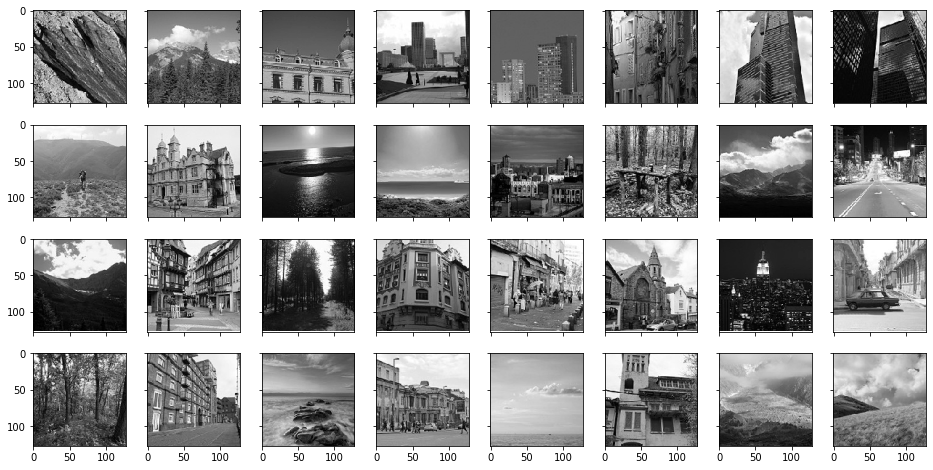

In [ ]:
sample_images = x_train[:100]

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, img in zip(grid, sample_images):
  ax.imshow(img.reshape(formatxy), cmap = "gray")

plt.show()

In [ ]:
maxElement_train = max(arr.max() for arr in x_train)
maxElement_test = max(arr.max() for arr in x_test)
maxElement = np.amax(np.array(maxElement_train, maxElement_test))
maxElement

1.0

In [ ]:
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, beat_pixels=0.5, batch_size=32, dim=(128, 128), n_channels=1, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X
      self.y = y
      self.beat_pixels = beat_pixels
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      self.on_epoch_end()
      for image in X:
        image = image*255
      for image in y:
        image = image*255
  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((32, 128, 128,1)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((32, 128, 128,1)) # Original image

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
      ## Get mask associated to that image
      masked_image = self.__createMask(image_copy)

      X_batch[i,] = masked_image
      y_batch[i] = self.y[idx]
    return X_batch, y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    masked_image = img.copy()
    for _ in range(int(self.beat_pixels*(128*128))):
      # Get random x locations to start line
      x1, y1 = np.random.randint(1, 127), np.random.randint(1, 127)
      masked_image[x1,y1] = 0
    return masked_image

In [ ]:
def createMask(img, beat_pixels=0.5):
    ## Prepare masking matrix
    masked_image = img.copy()
    for _ in range(int(beat_pixels*(128*128))):
      # Get random x locations to start line
      x1, y1 = np.random.randint(1, 128), np.random.randint(1, 128)
      masked_image[x1,y1] = 0
      
    return masked_image

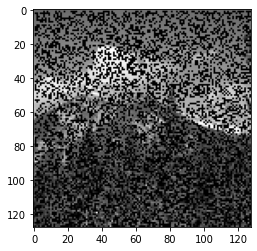

In [ ]:
plt.imshow(createMask(sample_images[1].reshape(formatxy)), cmap='gray');

In [ ]:
## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test, shuffle=False)

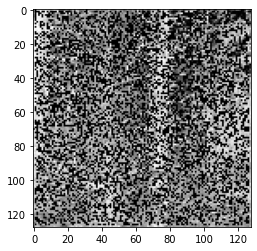

In [ ]:
## Examples
sample_idx = 10 ## Change this to see different batches
sample_images1, sample_masks1 = traingen[sample_idx]
im = sample_images1[0]*255*255
im = im.astype(np.uint8)
plt.imshow(im.reshape(formatxy), cmap = 'gray');

In [ ]:
## For more information into formulation: https://www.youtube.com/watch?v=AZr64OxshLo
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [ ]:
class inpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(128,128,1)):
    inputs = keras.layers.Input(input_size)
    print(inputs.shape)
    conv1, pool1 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(512, (3,3), (2,2), 'relu', 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(1024, (3,3), (2,2), 'relu', 'same', pool3) 
    
    conv5, up6 = self.__UpConvBlock(1024, 1024, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(512, 512, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(256, 256, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(128, 128, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    
    conv9 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', up9, False)
    
    outputs = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv9)

    return keras.models.Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

In [ ]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])

(None, 128, 128, 1)


In [ ]:
%%time
_ = model.fit(traingen, 
          validation_data=testgen, 
          epochs=10, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen))

Epoch 1/10
178/178 [==============================] - 559s 3s/step - loss: 0.0713 - dice_coef: 0.5758 - val_loss: 0.0429 - val_dice_coef: 0.5919
Epoch 2/10
178/178 [==============================] - 546s 3s/step - loss: 0.0399 - dice_coef: 0.5886 - val_loss: 0.0335 - val_dice_coef: 0.5881
Epoch 3/10
178/178 [==============================] - 545s 3s/step - loss: 0.0340 - dice_coef: 0.5905 - val_loss: 0.0411 - val_dice_coef: 0.5768
Epoch 4/10
178/178 [==============================] - 560s 3s/step - loss: 0.0326 - dice_coef: 0.5910 - val_loss: 0.0301 - val_dice_coef: 0.5879
Epoch 5/10
178/178 [==============================] - 539s 3s/step - loss: 0.0298 - dice_coef: 0.5916 - val_loss: 0.0281 - val_dice_coef: 0.5952
Epoch 6/10
178/178 [==============================] - 538s 3s/step - loss: 0.0306 - dice_coef: 0.5918 - val_loss: 0.0272 - val_dice_coef: 0.5926
Epoch 7/10
178/178 [==============================] - 540s 3s/step - loss: 0.0288 - dice_coef: 0.5925 - val_loss: 0.0271 - val_dic

In [ ]:
model.save('/content/drive/MyDrive/model_50')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_50/assets


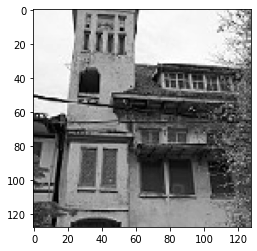

In [ ]:
plt.imshow(sample_images[29].reshape(128,128), cmap = 'gray')

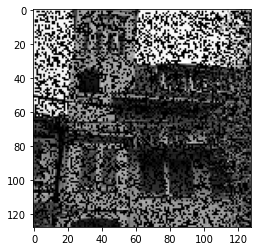

In [ ]:
masked_image1 = createMask(sample_images[29])
plt.imshow(masked_image1.reshape(128,128), cmap = 'gray')

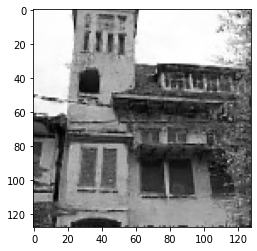

In [ ]:
resulting = model.predict(masked_image1.reshape((1,)+masked_image1.shape))
res = resulting.reshape(resulting.shape[1:])
plt.imshow(res.reshape(128,128), cmap = 'gray')

In [ ]:
for i in range(100):
  path1 = os.path.join(path,str(i)+'_groundtruth.jpg')
  path2 = os.path.join(path,str(i)+'_masked.jpg')
  path3 = os.path.join(path,str(i)+'_restrored.jpg')

  plt.imsave(path1, sample_images[i].reshape(128,128), cmap = 'gray')
  masked_image1 = createMask(sample_images[i])
  plt.imsave(path2, masked_image1.reshape(128,128), cmap = 'gray')
  resulting = model.predict(masked_image1.reshape((1,)+masked_image1.shape))
  res = resulting.reshape(resulting.shape[1:])
  plt.imsave(path3, res.reshape(128,128), cmap = 'gray')

In [ ]:
rez = (resulting - sample_images[29]).reshape(128,128)
print(rez.shape)

(128, 128)


In [ ]:
loss = np.linalg.norm(rez,1)/(128*128)
print(loss)

0.003343192394822836


In [ ]:
loss2 = np.linalg.norm(rez,2)/(128*128)
print(loss2)

0.0022466087248176336


70

In [ ]:
traingen = createAugment(x_train, x_train, 0.7)
testgen = createAugment(x_test, x_test, 0.7, shuffle=False)

In [ ]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])

(None, 128, 128, 1)


In [ ]:
%%time
_ = model.fit(traingen, 
          validation_data=testgen, 
          epochs=10, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen))

Epoch 1/10
178/178 [==============================] - 745s 4s/step - loss: 0.0851 - dice_coef: 0.5704 - val_loss: 0.0613 - val_dice_coef: 0.5923
Epoch 2/10
178/178 [==============================] - 706s 4s/step - loss: 0.0486 - dice_coef: 0.5855 - val_loss: 0.0426 - val_dice_coef: 0.5836
Epoch 3/10
178/178 [==============================] - 706s 4s/step - loss: 0.0420 - dice_coef: 0.5875 - val_loss: 0.0388 - val_dice_coef: 0.5910
Epoch 4/10
178/178 [==============================] - 702s 4s/step - loss: 0.0390 - dice_coef: 0.5883 - val_loss: 0.0360 - val_dice_coef: 0.5894
Epoch 5/10
178/178 [==============================] - 704s 4s/step - loss: 0.0359 - dice_coef: 0.5889 - val_loss: 0.0368 - val_dice_coef: 0.5848
Epoch 6/10
178/178 [==============================] - 701s 4s/step - loss: 0.0366 - dice_coef: 0.5894 - val_loss: 0.0338 - val_dice_coef: 0.5914
Epoch 7/10
178/178 [==============================] - 701s 4s/step - loss: 0.0347 - dice_coef: 0.5898 - val_loss: 0.0362 - val_dic

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_70/assets
0.0034327320754528046
0.0022412941325455904


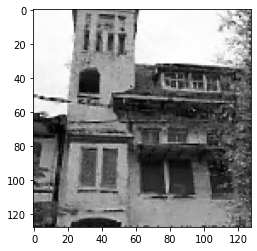

In [ ]:
model.save('/content/drive/MyDrive/model_70')

plt.imshow(sample_images[29].reshape(128,128), cmap = 'gray')
masked_image1 = createMask(sample_images[29])
plt.imshow(masked_image1.reshape(128,128), cmap = 'gray')

resulting = model.predict(masked_image1.reshape((1,)+masked_image1.shape))
res = resulting.reshape(resulting.shape[1:])
plt.imshow(res.reshape(128,128), cmap = 'gray')

for i in range(100):
  path1 = os.path.join(path,str(i)+'_groundtruth_70.jpg')
  path2 = os.path.join(path,str(i)+'_masked_70.jpg')
  path3 = os.path.join(path,str(i)+'_restrored_70.jpg')

  plt.imsave(path1, sample_images[i].reshape(128,128), cmap = 'gray')
  masked_image1 = createMask(sample_images[i])
  plt.imsave(path2, masked_image1.reshape(128,128), cmap = 'gray')
  resulting = model.predict(masked_image1.reshape((1,)+masked_image1.shape))
  res = resulting.reshape(resulting.shape[1:])
  plt.imsave(path3, res.reshape(128,128), cmap = 'gray')

rez = (resulting - sample_images[29]).reshape(128,128)

loss_1 = np.linalg.norm(rez, 1) / (128 * 128)
print(loss_1)

loss_2 = np.linalg.norm(rez, 2) / (128 * 128)
print(loss_2)

30

In [ ]:
traingen = createAugment(x_train, x_train, 0.3)
testgen = createAugment(x_test, x_test, 0.3, shuffle=False)

keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])


(None, 128, 128, 1)


In [ ]:
%%time
_ = model.fit(traingen, 
          validation_data=testgen, 
          epochs=10, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen))

Epoch 1/10
178/178 [==============================] - 389s 2s/step - loss: 0.0894 - dice_coef: 0.5681 - val_loss: 0.0485 - val_dice_coef: 0.5893
Epoch 2/10
178/178 [==============================] - 383s 2s/step - loss: 0.0387 - dice_coef: 0.5900 - val_loss: 0.0279 - val_dice_coef: 0.5893
Epoch 3/10
178/178 [==============================] - 383s 2s/step - loss: 0.0293 - dice_coef: 0.5926 - val_loss: 0.0297 - val_dice_coef: 0.6022
Epoch 4/10
178/178 [==============================] - 382s 2s/step - loss: 0.0247 - dice_coef: 0.5938 - val_loss: 0.0238 - val_dice_coef: 0.5988
Epoch 5/10
178/178 [==============================] - 383s 2s/step - loss: 0.0236 - dice_coef: 0.5945 - val_loss: 0.0252 - val_dice_coef: 0.6002
Epoch 6/10
178/178 [==============================] - 381s 2s/step - loss: 0.0221 - dice_coef: 0.5949 - val_loss: 0.0211 - val_dice_coef: 0.5980
Epoch 7/10
178/178 [==============================] - 379s 2s/step - loss: 0.0211 - dice_coef: 0.5951 - val_loss: 0.0231 - val_dic

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_30/assets
0.003379200352355838
0.0022667711600661278


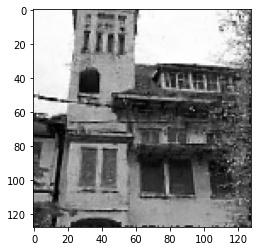

In [ ]:
model.save('/content/drive/MyDrive/model_30')

plt.imshow(sample_images[29].reshape(128,128), cmap = 'gray')
masked_image1 = createMask(sample_images[29])
plt.imshow(masked_image1.reshape(128,128), cmap = 'gray')

resulting = model.predict(masked_image1.reshape((1,)+masked_image1.shape))
res = resulting.reshape(resulting.shape[1:])
plt.imshow(res.reshape(128,128), cmap = 'gray')

for i in range(100):
  path1 = os.path.join(path,str(i)+'_groundtruth_30.jpg')
  path2 = os.path.join(path,str(i)+'_masked_30.jpg')
  path3 = os.path.join(path,str(i)+'_restrored_30.jpg')

  plt.imsave(path1, sample_images[i].reshape(128,128), cmap = 'gray')
  masked_image1 = createMask(sample_images[i])
  plt.imsave(path2, masked_image1.reshape(128,128), cmap = 'gray')
  resulting = model.predict(masked_image1.reshape((1,)+masked_image1.shape))
  res = resulting.reshape(resulting.shape[1:])
  plt.imsave(path3, res.reshape(128,128), cmap = 'gray')

rez = (resulting - sample_images[29]).reshape(128,128)

loss_1 = np.linalg.norm(rez, 1) / (128 * 128)
print(loss_1)

loss_2 = np.linalg.norm(rez, 2) / (128 * 128)
print(loss_2)